In [83]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

K = np.array([[215.6810060961547, 0.0, 376.5], [0.0, 215.6810060961547, 240.5], [0.0, 0.0, 1.0]],dtype=np.float32)

pontoReal = np.array([[5.5e-2, -5.5e-2, 0],
                    [5.5e-2, 5.5e-2, 0],
                    [-5.5e-2, 5.5e-2, 0],
                    [-5.5e-2, -5.5e-2, 0]], dtype=np.float32)

In [17]:
for i in range(0, 170):
    name = "/home/elton/Documentos/GitHub/drone_data/Mostrador1/img/frame" + ((4-len(str(i)))*"0"+str(i)) + ".jpg"

    img = cv.imread(name)

    quad = processaImagem(img)

    salvaTodosQuadrados(quad, img, i)

In [16]:
def procuraQuadrado(mascara):
    kernel = np.ones((5,5),np.uint8)
    
    bordas = cv.Canny(mascara, 100, 500, kernel)

    contours = []
    hierarchy = []

    if(cv.__version__[0] == "4"):
        contours,hierarchy = cv.findContours(bordas, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    else:
        _, contours, hierarchy = cv.findContours(bordas, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    quadrados = []

    for i in range(len(contours)):
        epsilon = 0.1*cv.arcLength(contours[i],True)
        approx = cv.approxPolyDP(contours[i],epsilon,True)

        if(len(approx) < 4):
            continue

        if not cv.isContourConvex(approx):
            continue

        if cv.contourArea(approx) < 2000:
            continue

        quadrado = []

        for point in approx:
            quadrado.append([point[0][0], point[0][1]])
        
        quadrados.append(quadrado)

    quadrados = np.array(quadrados)

    i = 0

    while(len(quadrados)-2 >= i):
        if np.linalg.norm(quadrados[i+1][0]-quadrados[i][0]) < 5:
            quadrados = np.delete(quadrados, i, 0)
            
        i+=1

    i = 0

    while len(quadrados) > i:
        if np.linalg.norm(quadrados[i][0]-quadrados[i][1])/np.linalg.norm(quadrados[i][2]-quadrados[i][1]) <0.9:
           quadrados = np.delete(quadrados, i, 0) 
        i+=1
        

    return quadrados

#Estima a pose do sensor a partir de seus cantos na imagem
def estimaPose(quad):
    global pontoReal
    a = 0
    RCamObj = []
    tCamObj = []
    try:
            a, RCamObj, tCamObj, _ = cv.solvePnPRansac(pontoReal,quad , K, np.zeros((5,1)))
    except:
        pontoI = np.expand_dims(quad, 1)
        pontoR = np.expand_dims(pontoReal, 1)
        a, RCamObj, tCamObj, _ = cv.solvePnPRansac(pontoR,pontoI , K, np.zeros((5,1), dtype=np.float32))

    #return RObjCamera, tObjCamera 

    return RCamObj, tCamObj

def salvaTodosQuadrados(quadrados, img, i):
    imgDraw = img.copy()
    
    if(len(quadrados) != 0):
        imgDraw = cv.circle(imgDraw, (0,0), 50, (0,0,255),-1)

    for quad in quadrados:
        for point in quad:
            cv.circle(imgDraw, (point[0], point[1]), 2, (255,0,0), -1)

    cv.imwrite("result/"+str(i)+".png", imgDraw)


def imprimeQuadrado(quadrado, img):
    imgDraw = img.copy()
    
    for point in quadrado:
        cv.circle(imgDraw, (point[0], point[1]), 2, (255,0,0), -1)

    plt.imshow(cv.cvtColor(imgDraw,cv.COLOR_BGR2RGB))
    plt.show()

def imprimeTodosQuadrados(quadrados, img):
    imgDraw = img.copy()
    for quad in quadrados:
        for point in quad:
            cv.circle(imgDraw, (point[0], point[1]), 2, (255,0,0), -1)
    
    plt.imshow(cv.cvtColor(imgDraw,cv.COLOR_BGR2RGB))
    plt.show()

def processaImagem(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    hls = cv.cvtColor(img, cv.COLOR_BGR2HLS)

    kernel = np.ones((5,5),np.uint8)

    min_preto = np.array([0,0,0],np.uint8)
    max_preto = np.array([180,255,40],np.uint8)

    min_branco = np.array([0,240,0], dtype=np.uint8)
    max_branco = np.array([180,255,255], dtype=np.uint8)

    masc_preto = cv.inRange(hsv,min_preto,max_preto)
    masc_branco = cv.inRange(hls,min_branco,max_branco)



    masc = cv.bitwise_or(masc_preto, masc_branco, np.ones_like(masc_branco))

    
    closing = cv.morphologyEx(masc, cv.MORPH_CLOSE, kernel, iterations=10)

    res = cv.bitwise_and(img, img, mask=closing)

    '''plt.imshow(masc)
    plt.show()

    plt.imshow(closing)
    plt.show()

    plt.imshow(res)
    plt.show()'''


    quadrados = procuraQuadrado(closing)

    return quadrados

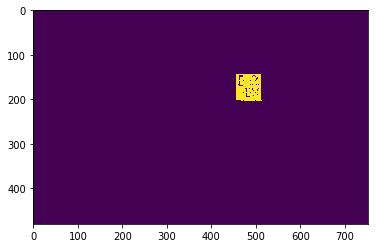

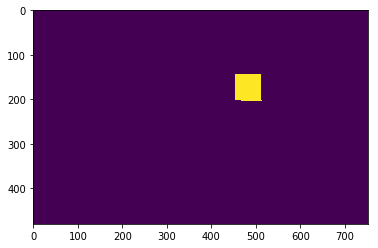

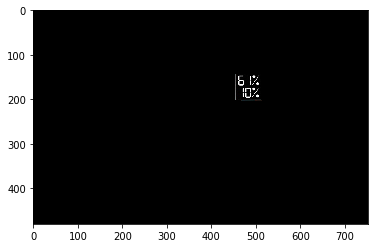

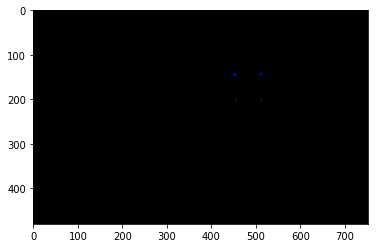

In [15]:
i = 140
name = "/home/elton/Documentos/GitHub/drone_data/Mostrador1/img/frame" + ((4-len(str(i)))*"0"+str(i)) + ".jpg"

img = cv.imread(name)

quad = processaImagem(img)


imprimeTodosQuadrados(quad, np.zeros_like(img))

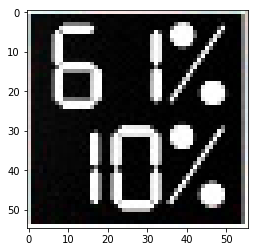

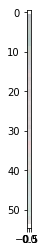

In [272]:
plt.imshow(img[223:278,411:467])
plt.show()

plt.imshow(img[223:278,411:412])
plt.show()

('h', 133, 0, 79.781818181818181)
('l', 254, 191, 212.56363636363636)
('s', 255, 0, 36.909090909090907)


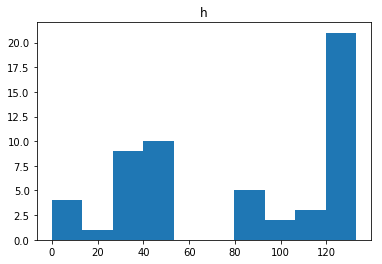

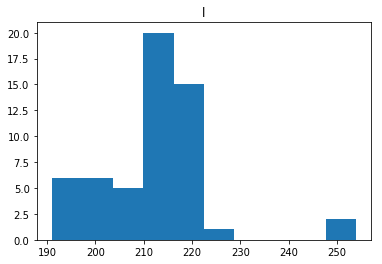

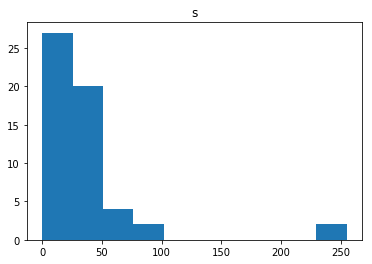

In [275]:
hls = cv.cvtColor(img[223:278,411:412], cv.COLOR_BGR2HLS)

vetor = hls.reshape(hls.shape[0]*hls.shape[1], 3)

h = vetor[:,0]
l = vetor[:,1]
s = vetor[:,2]

print("h", np.max(h), np.min(h), np.mean(h))
print("l", np.max(l), np.min(l), np.mean(l))
print("s", np.max(s), np.min(s), np.mean(s))

plt.title("h")
plt.hist(h)
plt.show()
plt.title("l")
plt.hist(l)
plt.show()
plt.title("s")
plt.hist(s)
plt.show()

In [275]:
percentual = cv.imread('percentual.png')
percentual = cv.rotate(percentual,cv.ROTATE_90_COUNTERCLOCKWISE)
percentual = cv.resize(percentual,(100,35))
percentual2 = cv.rotate(percentual,cv.ROTATE_90_COUNTERCLOCKWISE)

imgRotacionada = []

for i in range(170):
    try:

        img = cv.imread('result/'+str(i)+'.png')

        template = percentual[:,0:45]

        w = template.shape[1]
        h = template.shape[0]

        res = cv.matchTemplate(img,template,cv.TM_CCOEFF_NORMED)

        threshold = 0.5
        loc = np.where( res >= threshold)

        E = 0
        C = 0
        B = 0
        D = 0

        if(len(loc[0]) == 0):
            template = percentual2[:45,:]

            w = template.shape[1]
            h = template.shape[0]

            res = cv.matchTemplate(img,template,cv.TM_CCOEFF_NORMED)

            threshold = 0.5
            loc = np.where( res >= threshold)


            for pt in zip(*loc[::-1]):
                if(pt[0]<25 or pt[0] > 75) and (pt[1]<25 or pt[1] > 75):
                    continue
                    
                if(pt[0]>50):
                    D += 1
                else:
                    E += 1

        else:
           for pt in zip(*loc[::-1]):
                    
                if(pt[1]< 50):
                    C += 1
                else:
                    B += 1

        if E>D and E>B and E>C:
            #Esquerda
            img = cv.rotate(img,cv.ROTATE_180)
        elif B> D and B>C:
            #Baixo
            img = cv.rotate(img,cv.ROTATE_90_COUNTERCLOCKWISE)
        elif C>D:
            #Cima
            img = cv.rotate(img,cv.ROTATE_90_CLOCKWISE)
        elif D != 0:
            #Direita
            pass
        else:
            print("ERROR")
            #return
            pass

        imgRotacionada.append(img)

        #cv.imwrite('result2/'+str(i)+".png",img)
        ####################ACIMA FUNCIONA#######################

        _, th = cv.threshold(cv.cvtColor(img,cv.COLOR_BGR2GRAY),100,255,cv.THRESH_BINARY)
        cv.imwrite('result2/'+str(i)+".png",th)

        match = []

        for i in range(10):
            template = cv.imread('data/mostrador/'+str(j)+".png",0)
            w = template.shape[1]
            h = template.shape[0]

            res = cv.matchTemplate(th,template,cv.TM_CCOEFF_NORMED)

            threshold = 0.0
            loc = np.where( res >= threshold)

            if(len(loc[0]) == 0):
                pass
            
            match.append(len(loc[0]))

        print(match)

    except:
        pass

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[

In [196]:
template = cv.imread('data/mostrador/'+str(j)+".png")

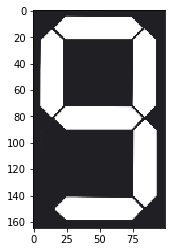

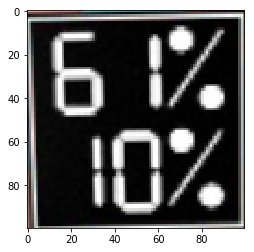

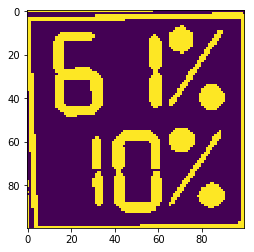

In [226]:
plt.imshow(template)
plt.show()
plt.imshow(img) #40x25
plt.show()
res,th3 = cv.threshold(cv.cvtColor(img,cv.COLOR_BGR2GRAY),100,255,cv.THRESH_BINARY)

plt.imshow(th3)
plt.show()

In [255]:
for i in range(10):
    name = "/home/elton/Documentos/GitHub/drone_data/Mostrador2/" + str(i) + ".png"
    img = cv.imread(name)

    dig = img[30:195,50:150]

    cv.imwrite('data/mostrador/'+str(i)+".png",dig)

In [287]:
def extraiDigitos(dig):
    ret,dig = cv.threshold(dig,127,255, cv.THRESH_BINARY)
    parte0 = dig[6:18,22:80]
    parte1 = dig[15:50,5:25]
    parte2 = dig[15:50,78:94]
    parte3 = dig[45:57,22:80]
    parte4 = dig[54:87,5:25]
    parte5 = dig[54:87,78:94]
    parte6 = dig[85:95,22:80]

    verifparte0 = cv.countNonZero(parte0)
    verifparte1 = cv.countNonZero(parte1)
    verifparte2 = cv.countNonZero(parte2)
    verifparte3 = cv.countNonZero(parte3)
    verifparte4 = cv.countNonZero(parte4)
    verifparte5 = cv.countNonZero(parte5)
    verifparte6 = cv.countNonZero(parte6)

    verif = [verifparte0, verifparte1, verifparte2, verifparte3, verifparte4, verifparte5, verifparte6]
    for i in range(len(verif)):
        if verif[i] > 200:
            verif[i] = 1
        else:
            verif[i] = 0
    
    if verif[0]==1 and verif[1]==1 and verif[2]==1 and verif[3]==0 and verif[4]==1 and verif[5]==1 and verif[6]==1:
        return 0
    elif verif[0]==0 and verif[1]==0 and verif[2]==1 and verif[3]==0 and verif[4]==0 and verif[5]==1 and verif[6]==0:
        return 1
    elif verif[0]==1 and verif[1]==0 and verif[2]==1 and verif[3]==1 and verif[4]==1 and verif[5]==0 and verif[6]==1:
        return 2
    elif verif[0]==1 and verif[1]==0 and verif[2]==1 and verif[3]==1 and verif[4]==0 and verif[5]==1 and verif[6]==1:
        return 3
    elif verif[0]==0 and verif[1]==1 and verif[2]==1 and verif[3]==1 and verif[4]==0 and verif[5]==1 and verif[6]==0:
        return 4
    elif verif[0]==1 and verif[1]==1 and verif[2]==0 and verif[3]==1 and verif[4]==0 and verif[5]==1 and verif[6]==1:
        return 5
    elif verif[0]==1 and verif[1]==1 and verif[2]==0 and verif[3]==1 and verif[4]==1 and verif[5]==1 and verif[6]==1:
        return 6
    elif verif[0]==1 and verif[1]==0 and verif[2]==1 and verif[3]==0 and verif[4]==0 and verif[5]==1 and verif[6]==0:
        return 7
    elif verif[0]==1 and verif[1]==1 and verif[2]==1 and verif[3]==1 and verif[4]==1 and verif[5]==1 and verif[6]==1:
        return 8
    elif verif[0]==1 and verif[1]==1 and verif[2]==1 and verif[3]==1 and verif[4]==0 and verif[5]==1 and verif[6]==1:
        return 9

def converte_coord(valor):
    pts1 = ([0,0],[24,0],[24,44],[0,44])
    pts1 = np.asarray(pts1, dtype = np.float32)
    pts2 = np.float32([[0,0],[100,0], [100,100], [0,100]])

    M = cv.getPerspectiveTransform(pts1,pts2)
    img2 = cv.warpPerspective(valor,M,(100,100))
    return img2

In [290]:
nErro = 0

for i in range(len(imgRotacionada)):
    _, th = cv.threshold(cv.cvtColor(imgRotacionada[i],cv.COLOR_BGR2GRAY),100,255,cv.THRESH_BINARY)

    dig11 = th[3:48,12:37]
    dig12 = th[3:48,40:64]
    dig21 = th[48:94, 12:37]
    dig22 = th[48:94,40:63]

    dig = [dig11, dig12,dig21, dig22]

    retorno = []
    for j in range(len(dig)):
        dig[j] = converte_coord(dig[j])
        retorno.append(extraiDigitos(dig[j]))

    #print(retorno)

    if(retorno[2] == None):
        retorno[2] = '-'

    if(retorno[0] == None):
        retorno[0] = "N"
        nErro+=1
    if(retorno[1] == None):
        retorno[1] = "N"
        nErro+=1
    if(retorno[3] == None):
        retorno[3] = "N"
        nErro+=1

    text = str(retorno[0])  +str(retorno[1]) +str(retorno[2]) +str(retorno[3]) 

    imgDraw = imgRotacionada[i].copy()

    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(imgDraw,text,(0,100), font, 1,(255,255,255),2,cv.LINE_AA)   
    cv.imwrite('result3/'+str(i)+".png",imgDraw)

print(nErro)

19


In [251]:
th 

array([[255, 255, 255, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255, 255],
       ..., 
       [255,   0,   0, ..., 255, 255, 255],
       [255,   0,   0, ..., 255, 255, 255],
       [255,   0,   0, ..., 255, 255, 255]], dtype=uint8)